# BOS 311 Service Requests Analysis

### Scenario: The Boston mayor and his cabinet have asked the Citywide Analytics Team to look into all cases submitted to BOS: 311 in January 2020 to understand current constituent concerns and performance trends across city departments

### Libraries and module required for the project

In [1]:
import pandas as pd
import numpy as np 
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from AssociationAnalysis import cases # Custom module, will be used to calculate support and lift for association analysis  
from sklearn import preprocessing 


### Extracting publicly available dataset, and describing the data

#### Data availibility: The dataset is available at Analyze Boston (https://data.boston.gov/) Data URL is (https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/6ff6a6fd-3141-4440-a880-6f60a37fe789/download/tmpt1d4qk7n.csv)

#### A brief bout the data and it's content

* TYPE: Tabular
* DESCRIPTION: This data set includes all channels of engagement in which a service request is created.
* SOURCE: City Constituent Relationship Management (CRM) system
* PUBLISHER: Department of Innovation and Technology
* UPDATE FREQUENCY:	Daily

#### Columns and it's content 
* case_enquiry_id: Unique case identifier
* open_dt: Date when the service request was created
* target_dt: Auto assigned or requested date of resolution
* closed_dt: Actual date of resolution
* ontime: If the service request was resolved Ontime or Overdue
* case_status: Current status of the case
* case_title: Title given to a case. Most titles are self evident. This field is entered by call takers on a call by call basis
* subject: Part of a case classification hierarchy (SUBJECT > REASON > TYPE) Subhect denotes which department a case is assigned to
* reason: Part of a case classification hierarchy (SUBJECT > REASON > TYPE) This is an overall ‘umbrella’ for acollection o fsimilar case types
* type: Part of a case classification hierarchy (SUBJECT > REASON > TYPE) Individual case type entered by call taker
* queue: Queue a case is assigned to. There are multiple queues within many departments which reflect the nature of the case
* department: Department a case is assigned to. This value is derived from the first 4 digits of the queue column
* submittedphoto: URL of the image submitted by the user
* closedphoto: URL of the image uploaded by the resolver group, post resolution
* location: Location where the service has to be full filled
* fire_district: BFD fire district case is within. There are 2 divisions and 9 districts. Division 1 is comprised of Districts 1,3 (includes old district 2), 4, 6, and 11. Division 2 is comprised of Division 7, 8, 9, and 12
* city_council_district: City Council district a case falls within
* neighborhood: Neighborhood relayed by caller and entered by call taker. There are redundancies and missing values within this field
* neighborhood_services_district: Districts under the Office of Neighborhood Services, a City of Boston office that encourages, facilitates and maximizes citizen input and participation in all aspects of government through service requests, neighborhood meetings, mailings, and emergency responses
* ward: Election ward a case falls within
* location_zipcode: Zip code a case falls within
* source: The source through which a service was requested

In [2]:
#Dataset URL
url = 'https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/6ff6a6fd-3141-4440-a880-6f60a37fe789/download/tmpt1d4qk7n.csv'
bdata = pd.read_csv(url, usecols = ['case_enquiry_id', 'open_dt', 'closed_dt', 'ontime', 'case_status', 'case_title',
                                    'subject', 'reason', 'type', 'queue', 'department', 'submittedphoto', 
                                    'closedphoto', 'fire_district', 'city_council_district', 'neighborhood',
                                    'neighborhood_services_district', 'ward', 'location_zipcode', 'source'], header = 0,
                    low_memory = True)

#The original data types of the data frame stored in variable original_Dtypes
original_Dtypes = bdata.dtypes


### How will the analysis help?
#### This is an analysis with observations and potential items for further analysis or action for the Mayor and the Analytics Team to take. It includes data visualizations that will help illustrate findings and recommendations

#### Possible topics for analysis include:

* What general trends do you see in constituent engagement? 
* What services are people requesting? 
* What do you see at a neighborhood level? 
* City Operations: How long does it take to complete a request?
* What do you see at the departmental-level? 
* What are areas that the City should focus on and what areas has the City done well in?  
* How would you work with departments to improve City services? 
* Are there problems you see in the dataset that would pose challenges to future analyses? 
* How can the City use the information in this dataset—both within City Hall and with the public—to better connect with communities?

### Data cleaning using fillna() to fill missing values like NaN, NaT or NA and replace() to replace white spaces, regex to specify the regular text expressions, astype() to change the column datatype, and cat.add_categories() to add a value to categorical datatypes
### Made use of cat.add_categories() to add a category; this is to resolve missing value in a column of Category type

In [3]:
#Setting the image url to true, only to get the count of submissions
bdata.closedphoto.replace('^https:.*', 'True', regex = True, inplace = True)
bdata.submittedphoto.replace('^https:.*', 'True', regex = True, inplace = True)

#Filling the NaN values in columns submittedphoto and closedphoto with False
try:
    bdata['submittedphoto'] = pd.Categorical(bdata.submittedphoto)
    bdata['submittedphoto'] = bdata['submittedphoto'].cat.add_categories('False')
except:
    pass
bdata['submittedphoto'].fillna('False', inplace = True)

try:
    bdata['closedphoto'] = pd.Categorical(bdata.closedphoto)
    bdata['closedphoto'] = bdata['closedphoto'].cat.add_categories('False')
except:
    pass
bdata['closedphoto'].fillna('False', inplace = True)

#Removing Ward n from the column ward
bdata.ward.replace('^Ward ', '', regex = True, inplace = True)
bdata.ward.replace(' ', 0, inplace = True)

#Managing missing values from the column location_zipcode
bdata['location_zipcode'].fillna('No Zip code', inplace = True)
bdata.location_zipcode.replace(' ', 0, inplace=True)


#Restructure neighborhood_services_district column; this will be used with apriori()
bdata.neighborhood_services_district.replace(' ', 0, inplace = True)
bdata['neighborhood_services_district'].fillna(0, inplace = True)
bdata['neighborhood_services_district'] = bdata['neighborhood_services_district'].astype('int32')

#Converting the columns open_dt and closed_dt, from object to date
bdata['open_dt'] = pd.to_datetime(bdata['open_dt'])
bdata['closed_dt'] = pd.to_datetime(bdata['closed_dt'])

#Converted the below columns from object to categories
bdata['ontime'] = pd.Categorical(bdata.ontime)
bdata['case_status'] = pd.Categorical(bdata.case_status)
bdata['subject'] = pd.Categorical(bdata.subject)
bdata['type'] = pd.Categorical(bdata.type)
bdata['queue'] = pd.Categorical(bdata.queue)
bdata['location_zipcode'] = pd.Categorical(bdata.location_zipcode)
bdata['closedphoto'] = pd.Categorical(bdata.closedphoto)

#Managing missing values in the columns fire_district and city_council_district
#fire and city are the variables created to be used while ploting histogram
bdata['fire_district'] = pd.Categorical(bdata.fire_district)
try:
    bdata['fire_district'] = bdata['fire_district'].cat.add_categories(0)
except:
    pass
bdata['fire_district'].fillna(0, inplace=True)
bdata.fire_district.replace(' ', 0, inplace=True)
fire = bdata['fire_district']
fire = fire.astype('int32')

#Cleaning the column city_council_district
bdata['city_council_district'] = pd.Categorical(bdata.city_council_district)
try:
    bdata['city_council_district'] = bdata['city_council_district'].cat.add_categories(0)
except:
    pass
bdata['city_council_district'].fillna(0, inplace=True)
bdata.city_council_district.replace(' ', 0, inplace=True)
city = bdata['city_council_district']
city = city.astype('int32')

#Clean up the neignborhood column with exception handling
try:
    bdata['neighborhood'] = pd.Categorical(bdata.neighborhood)
    bdata['neighborhood'] = bdata['neighborhood'].cat.add_categories('None')
except:
    pass
bdata.neighborhood.replace(' ', 'None', inplace=True)
bdata['neighborhood'].fillna('None', inplace = True)

#Clean up the ward column with exception handling
try:
    bdata['ward'] = pd.Categorical(bdata.ward)
    bdata['ward'] = bdata['ward'].cat.add_categories('None')
except:
    pass
bdata.ward.replace(' ', 'None', inplace=True)
bdata['ward'].fillna('None', inplace = True)

#Clean up the source column with exception handling
try:
    bdata['source'] = pd.Categorical(bdata.source)
except:
    pass

#Column case_title will be a string type
bdata['case_title'] = bdata.case_title.astype('string')

#converted_Dtypes is a variable that holds datatype of the data frame after converting the column types
converted_Dtypes = bdata.dtypes


### Below is list of column names and its datatype, before and after convetion.

In [4]:
print('Datatypes of data frame bdata before convertion \n\n', original_Dtypes, '\n-------' '\n\n Datatypes of data frame bdata after convertion \n\n', converted_Dtypes)

Datatypes of data frame bdata before convertion 

 case_enquiry_id                     int64
open_dt                            object
closed_dt                          object
ontime                             object
case_status                        object
case_title                         object
subject                            object
reason                             object
type                               object
queue                              object
department                         object
submittedphoto                     object
closedphoto                        object
fire_district                      object
city_council_district              object
neighborhood                       object
neighborhood_services_district     object
ward                               object
location_zipcode                  float64
source                             object
dtype: object 
-------

 Datatypes of data frame bdata after convertion 

 case_enquiry_id                   

### General trends in constituent engagement

### Observation: People have used Citizens Connect App the most to log a service request. Until today starting from Jan, 22760 Service requests were logged using Citizens Connect App

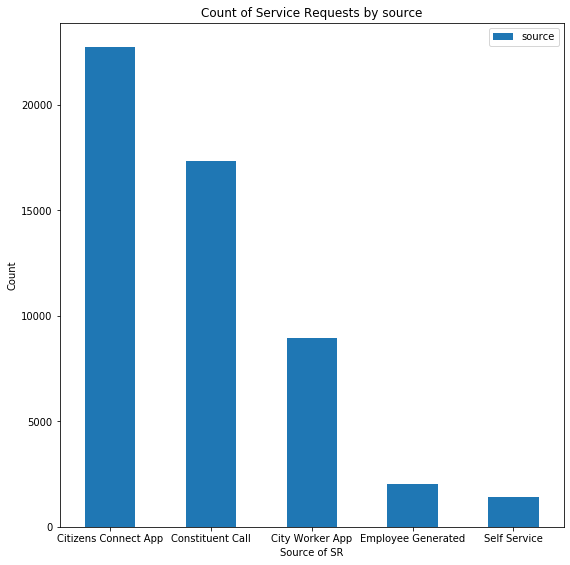

Citizens Connect App    22760
Constituent Call        17345
City Worker App          8973
Employee Generated       2047
Self Service             1392
Name: source, dtype: int64

In [5]:
source = bdata['source'].value_counts()
source.cumsum()
source_plt = plt.figure(figsize = [7,7]) 
source_ax = source_plt.add_axes([0,0,1,1])
source.plot(kind = 'bar')
source_ax.set_title('Count of Service Requests by source')
source_ax.set_xlabel('Source of SR')
source_ax.set_ylabel('Count')
plt.xticks(rotation='horizontal')
plt.legend(loc='best')
plt.show()
source

### Service request satus by Subject. Ontime and Overdue frequency
### Observation: Public Works Department and Transportation - Traffic Division has high response rate. Interestingly, they are also the cases that are overdue

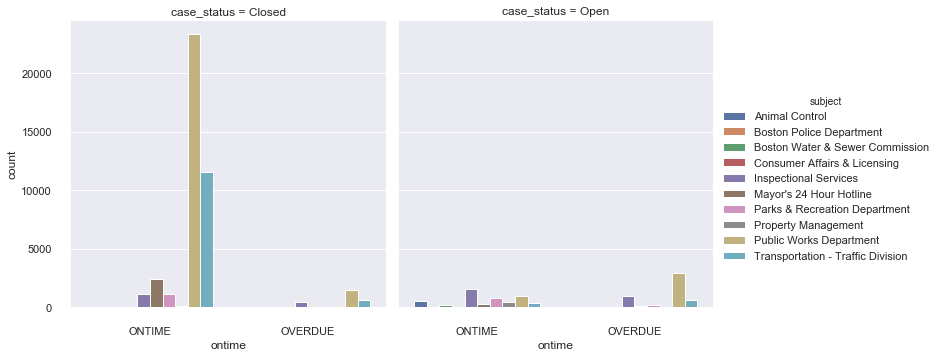

In [6]:
sns.set(style="whitegrid", color_codes=True)
sns.set(rc={'figure.figsize':(9,9)})
sns.catplot(x='ontime', hue='subject', col='case_status', data=bdata, kind='count')
sns.despine(offset=10, trim=True)

### Number of days to resolution for each department by Subject of the service request
### Introduced a new column, 'res_days' that holds the difference between open date and closed date of a case in days
### Observation: Mayor's 24 Hour Hotline, Public Work Department, Transportantion, Parks & Recreation have good rate of ontime resolution

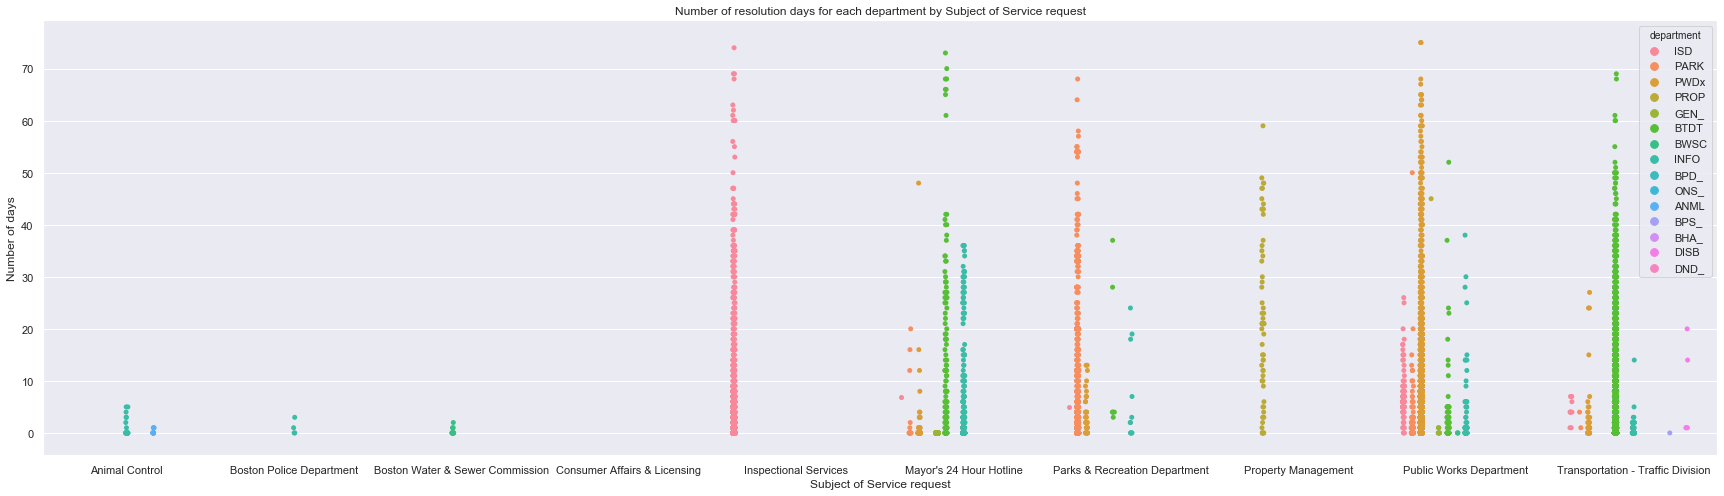

In [7]:
bdata['res_days'] = (bdata['closed_dt'] - bdata['open_dt']).dt.days
sns.set(rc={'figure.figsize':(30,8)})
sns.despine(offset=10, trim=True)
fig = sns.stripplot(x='subject', y='res_days', data=bdata, jitter=True, hue='department', dodge=True)
plt.title('Number of resolution days for each department by Subject of Service request')
plt.ylabel('Number of days')
plt.xlabel('Subject of Service request')
plt.show(fig)

### Resolution trend for each wards by subject of the service request
### Observations
* Property management has a longer resolution days trend; a few are over a month
* Boston Police Department, Boston Water & Sewer Commission, Public Work Department has uniform resolution days across all the wards
* Mayor's 24 Hour Hotline and Parks & Recreation Department are the only two case subjects that have varied fluctuation in resolution days for each wards

<Figure size 2160x576 with 0 Axes>

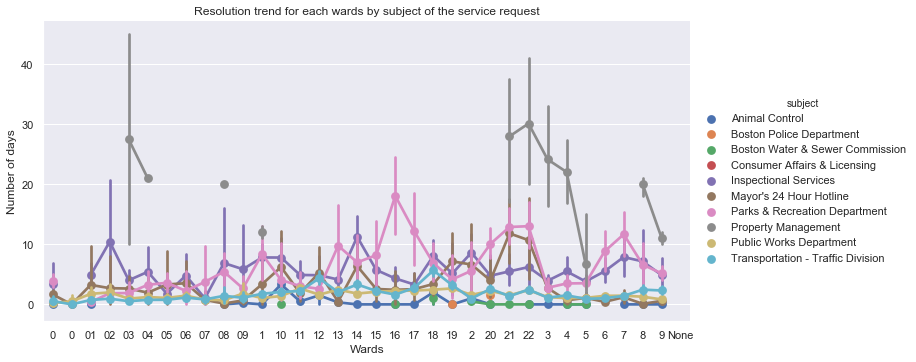

In [8]:
bdata['res_days'] = (bdata['closed_dt'] - bdata['open_dt']).dt.days
sns.despine(offset=30, trim=True)
fig = sns.factorplot(x='ward', y='res_days', data=bdata, hue='subject', aspect=40/20)
plt.title('Resolution trend for each wards by subject of the service request')
plt.xlabel('Wards')
plt.ylabel('Number of days')
plt.show(fig)

### Max, Min, and Mean number of days for Service request resolution?

In [9]:
#Used from the formula, Number of days for resolution = Closed date - Open date
bdata['res_days'].describe()

count    42364.000000
mean         2.137168
std          5.994808
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         75.000000
Name: res_days, dtype: float64

### At the Neighborhood level
### Observation: Dorchester has the highest number of cases registered. Followed by Roxberry so forth and so on by other neighborhoods (scroll to left to see the entire plot)

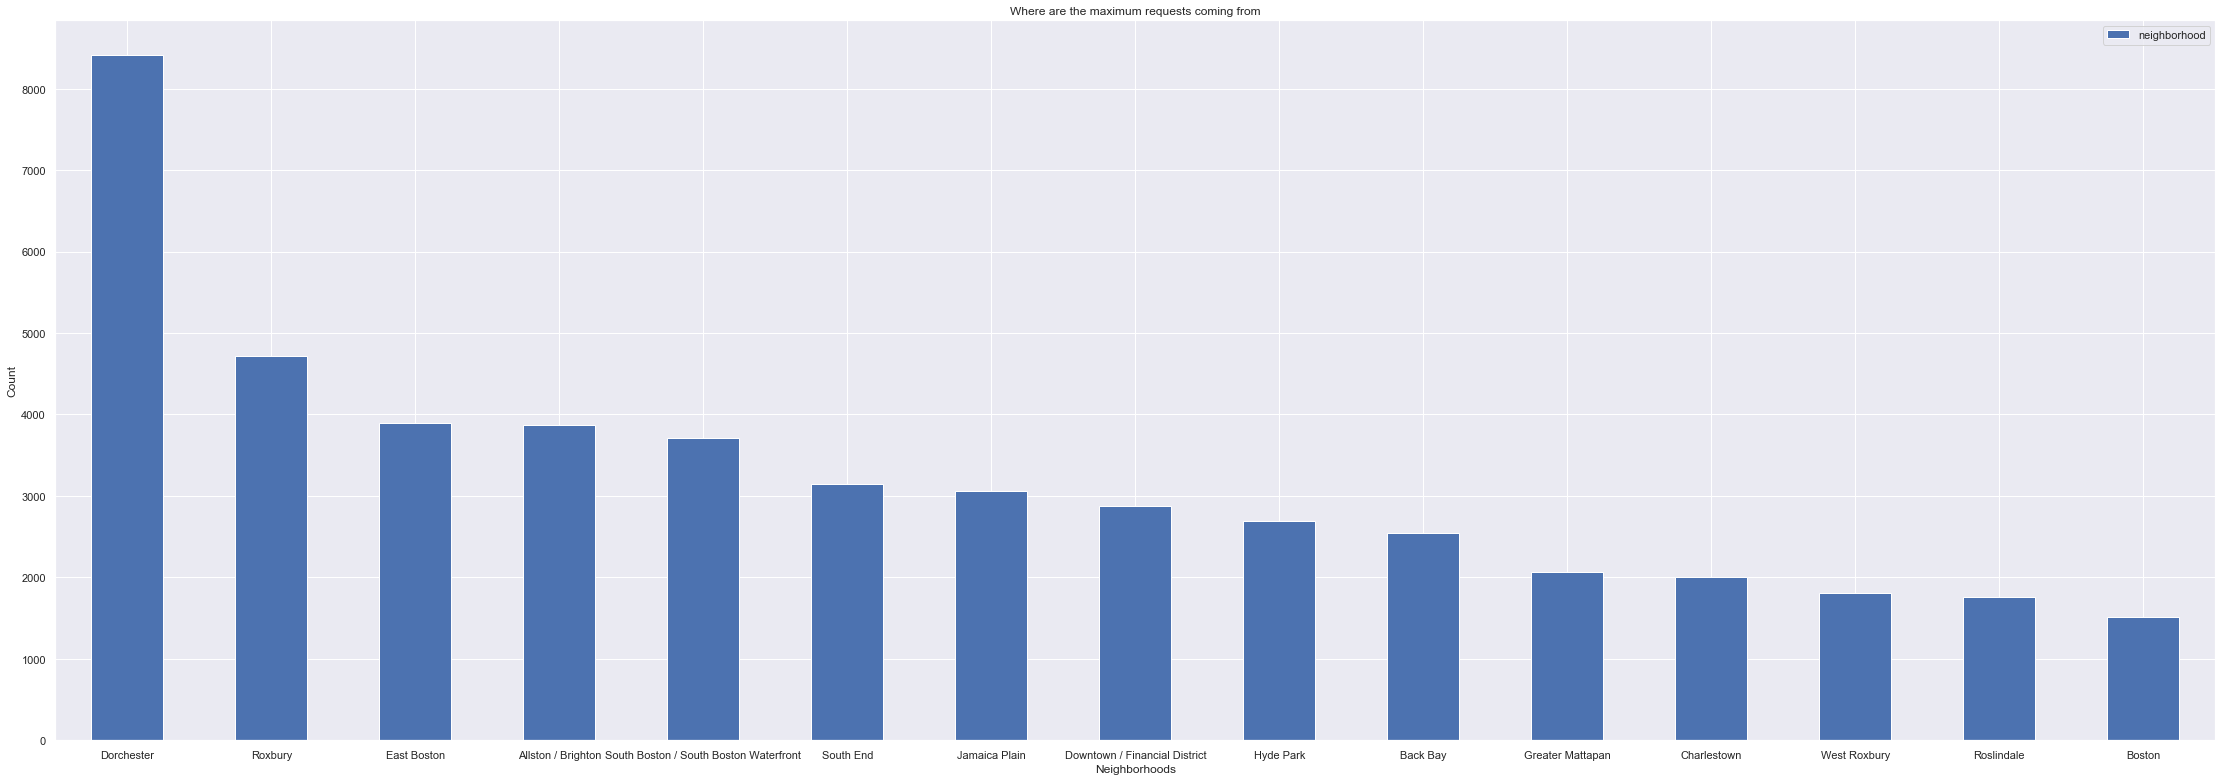

Top 15 Neighborhoods


Dorchester                                8418
Roxbury                                   4712
East Boston                               3895
Allston / Brighton                        3876
South Boston / South Boston Waterfront    3708
South End                                 3148
Jamaica Plain                             3061
Downtown / Financial District             2881
Hyde Park                                 2687
Back Bay                                  2542
Greater Mattapan                          2070
Charlestown                               2002
West Roxbury                              1807
Roslindale                                1754
Boston                                    1516
Name: neighborhood, dtype: int64

In [10]:
neighbor = bdata['neighborhood'].value_counts(sort = True, dropna = True)
neighbor = neighbor.iloc[:15]
neighbor_plt = plt.figure(figsize = [30,10]) 
neighbor_ax = neighbor_plt.add_axes([0,0,1,1])
neighbor.plot(kind = 'bar')
neighbor_ax.set_title('Where are the maximum requests coming from')
neighbor_ax.set_xlabel('Neighborhoods')
neighbor_ax.set_ylabel('Count')
plt.xticks(rotation='horizontal')
plt.legend(loc='best')
plt.show()
print('Top 15 Neighborhoods')
neighbor

### Service request frequency histogram by Fire district and City council district
### Observations
* District 0 has ~ equal frequency of cases, with District 1 and 2, City council has almost twice the frequency
* Districts 3 through 5 and 6 through 9, both Fire and City council have ~ equal frequency
* At the the districts where there are no cases from Fire there are as well no cases logged from city council
* Highest number of City council cases are from District 2 and highest number of Fire district cases are from District 11 where there is no overlap of fire and city council district frequency

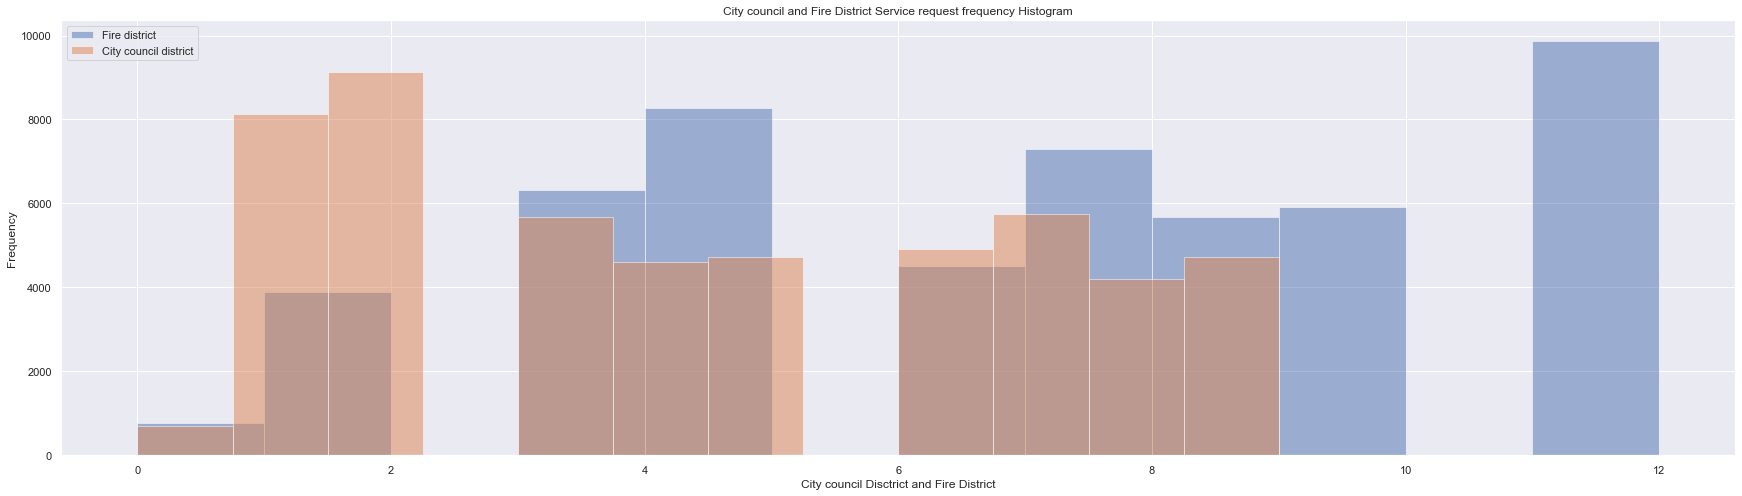

In [11]:
#Histogram to show Service Request frequency from City council and Fire council districts
plt.hist(fire, bins = 12, alpha = 0.5, label = 'Fire district')
plt.hist(city, bins = 12, alpha = 0.5, label = 'City council district')
plt.xlabel('City council Disctrict and Fire District')
plt.ylabel('Frequency')
plt.title('City council and Fire District Service request frequency Histogram')
plt.legend(loc='best')
plt.show()

### Rate of resolution; Ontime Vs Overdue
### Observation: 85.73 % of cases were resolved ontime and 14.27 % of cases are overdue

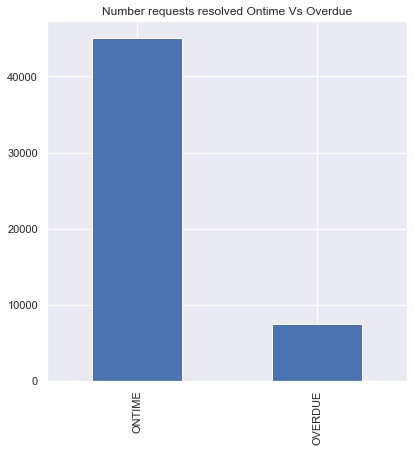


 85.73 % of cases were resolved ontime and 14.27 % of cases are overdue 

ONTIME     45024
OVERDUE     7493
Name: ontime, dtype: int64


In [12]:
ontime = bdata['ontime'].value_counts(sort = True, dropna = True)
ontime_plt = plt.figure(figsize = [5,5]) 
ontime_ax = ontime_plt.add_axes([0,0,1,1])
ontime.plot(kind = 'bar')
plt.title('Number requests resolved Ontime Vs Overdue')
plt.show()
ot = round(100 * (ontime[0]/sum(ontime)),2)
od = round(100 * (ontime[1]/sum(ontime)),2)
print('\n', ot, '% of cases were resolved ontime and', od, '% of cases are overdue \n')
print(ontime)

### Service requests by status
### Observation: 80.67 % of cases are in closed status and 19.33 % of cases are in open status

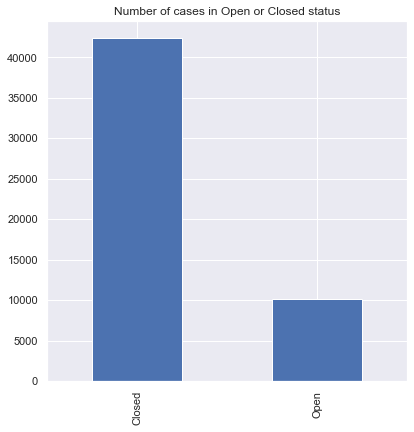


 80.67 % of cases are in closed status and 19.33 % of cases are in open status 

Closed    42364
Open      10153
Name: case_status, dtype: int64


In [13]:
status = bdata['case_status'].value_counts(sort = True, dropna = True)
status_plt = plt.figure(figsize = [5,5]) 
status_ax = status_plt.add_axes([0,0,1,1])
status.plot(kind = 'bar')
plt.title('Number of cases in Open or Closed status')
plt.show()
cl = round(100 * (status[0]/sum(status)),2)
op = round(100 * (status[1]/sum(status)),2)
print('\n', cl, '% of cases are in closed status and', op, '% of cases are in open status \n')
print(status)

## Data mining with Association Analysis (Neighborhood level) using mlxtend

### Association analysis helps us explore relationship between entities in a relational database. Shopping recommendation system is one of the examples of applications of Association analysis. For the is project, I have used mlextend package to complete the association analysis. Allow me to walk you through the steps

#### Importing the necessary packages

In [14]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

### Restructuring the columns

In [15]:
bdata['reason'] = bdata['reason'].astype('str')
bdata['reason'] = bdata['reason'].str.strip()
bdata['department'] = bdata['department'].astype('str')
closeCase = (bdata[bdata['case_status'] == 'Closed'].groupby(['department', 'reason'])
             ['neighborhood_services_district'].sum().unstack().reset_index().fillna(0).set_index('department'))


### cases is a method improted from the  AssociationAnalysis module, at the beginning of the project

In [16]:
pd.set_option('display.max_columns', None)
closeCase_collection =  closeCase.applymap(cases)
frequent_cases = apriori(closeCase_collection, min_support = 0.01, use_colnames = True)

### Association at the departmental-level
### Below is the boolean table used to expose any relationship between Department and Reason columns for all the cases that are in closed status.

In [17]:
pd.set_option('display.max_colwidth', -1)
closeCase_collection

reason,Abandoned Bicycle,Administrative & General Requests,Air Pollution Control,Animal Issues,Boston Bikes,Building,Catchbasin,Cemetery,Code Enforcement,Employee & General Comments,Enforcement & Abandoned Vehicles,Environmental Services,Fire Hydrant,Generic Noise Disturbance,Graffiti,Health,Highway Maintenance,Housing,Needle Program,Noise Disturbance,Notification,Office of The Parking Clerk,Operations,Park Maintenance & Safety,Parking Complaints,Recycling,Sanitation,Sidewalk Cover / Manhole,Signs & Signals,Street Cleaning,Street Lights,Traffic Management & Engineering,Trees,Weights and Measures
department,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ANML,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BPS_,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BTDT,1,1,0,0,1,0,0,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,1,1,1,0,0,0,1,1,1,1,1,0
BWSC,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
DISB,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
GEN_,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
INFO,0,1,1,1,0,0,0,0,1,1,1,0,0,1,0,0,1,0,0,1,1,0,0,1,0,0,1,0,1,1,1,1,1,0
ISD,0,1,0,0,0,1,0,0,1,0,1,1,0,0,0,1,1,1,0,0,0,0,0,1,0,0,1,0,1,1,0,0,0,1
PARK,0,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0


### Interesting observation: In support to the above table, below case resons have at least 50% support. Which means, at least 50% of times these cases resons were created together or were from the same neighnborhood_service_district

In [18]:
pd.set_option('display.max_colwidth', -1)
frequent_cases = frequent_cases[frequent_cases['support'] >= 0.5]
frequent_cases

,support,itemsets
1,0.636364,(Administrative & General Requests)
7,0.545455,(Code Enforcement)
9,0.636364,(Enforcement & Abandoned Vehicles)
15,0.636364,(Highway Maintenance)
26,0.545455,(Signs & Signals)
27,0.545455,(Street Cleaning)
55,0.545455,"(Administrative & General Requests, Enforcement & Abandoned Vehicles)"
60,0.545455,"(Highway Maintenance, Administrative & General Requests)"
70,0.545455,"(Signs & Signals, Administrative & General Requests)"
147,0.545455,"(Street Cleaning, Code Enforcement)"


#### To show the relative frequency of Antecedents, and Consequents. Below is the confidence and lift matrix

In [19]:
likely_conditions = association_rules(frequent_cases, metric = 'lift', min_threshold = 1)
likely_conditions.sort_values(by=['confidence'], ascending = False, inplace = True)
likely_conditions[(likely_conditions['lift'] >= 1) & (likely_conditions['confidence'] >= 0.7)]


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
4,(Signs & Signals),(Administrative & General Requests),0.545455,0.636364,0.545455,1.000000,1.571429,0.198347,inf
6,(Street Cleaning),(Code Enforcement),0.545455,0.545455,0.545455,1.000000,1.833333,0.247934,inf
7,(Code Enforcement),(Street Cleaning),0.545455,0.545455,0.545455,1.000000,1.833333,0.247934,inf
8,(Signs & Signals),(Enforcement & Abandoned Vehicles),0.545455,0.636364,0.545455,1.000000,1.571429,0.198347,inf
10,"(Signs & Signals, Administrative & General Requests)",(Enforcement & Abandoned Vehicles),0.545455,0.636364,0.545455,1.000000,1.571429,0.198347,inf
11,"(Signs & Signals, Enforcement & Abandoned Vehicles)",(Administrative & General Requests),0.545455,0.636364,0.545455,1.000000,1.571429,0.198347,inf
12,"(Administrative & General Requests, Enforcement & Abandoned Vehicles)",(Signs & Signals),0.545455,0.545455,0.545455,1.000000,1.833333,0.247934,inf
13,(Signs & Signals),"(Administrative & General Requests, Enforcement & Abandoned Vehicles)",0.545455,0.545455,0.545455,1.000000,1.833333,0.247934,inf
0,(Administrative & General Requests),(Enforcement & Abandoned Vehicles),0.636364,0.636364,0.545455,0.857143,1.346939,0.140496,2.545455
1,(Enforcement & Abandoned Vehicles),(Administrative & General Requests),0.636364,0.636364,0.545455,0.857143,1.346939,0.140496,2.545455


### Implementing ML packages from sklearn to predict case_status
#### Transforming colums to support build the models

In [20]:
enc = preprocessing.LabelEncoder()
bdata['case_status'] = enc.fit_transform(bdata['case_status'])
bdata['subject'] = enc.fit_transform(bdata['subject'])
bdata['reason'] = enc.fit_transform(bdata['reason'])
bdata['ontime'] = enc.fit_transform(bdata['ontime'])
bdata['type'] = enc.fit_transform(bdata['type'])
bdata['queue'] = enc.fit_transform(bdata['queue'])
bdata['fire_district'] = enc.fit_transform(fire)
bdata['city_council_district'] = enc.fit_transform(city)
bdata['department'] = enc.fit_transform(bdata['department'])
bdata['neighborhood'] = enc.fit_transform(bdata['neighborhood'])
bdata['neighborhood_services_district'] = enc.fit_transform(bdata['neighborhood_services_district'])
bdata['res_days'] = enc.fit_transform(bdata['res_days'])
bdata['location_zipcode'] = bdata['location_zipcode'].astype('str')
bdata['location_zipcode'] = enc.fit_transform(bdata['location_zipcode'])
bdata['source'] = enc.fit_transform(bdata['source'])


In [21]:
# Droping the colums that are not required to build model
fields = [field for field in bdata.columns if field not in ['case_enquiry_id', 'open_dt', 'closed_dt', 'case_title',
                                                            'case_status', 'submittedphoto', 'closedphoto']]
filtered_data = bdata[fields]
target = bdata['case_status']


### Importing sklearn modules

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
data_train, data_test, target_train, target_test = train_test_split(filtered_data,target, test_size = 0.20, random_state = 10)

### Starting with Naive Bayes, a categorical predictive algorithm. Please note the model accuracy

In [23]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

predgnb = gnb.fit(data_train, target_train).predict(data_test)
print('Navie Bayes model accuracy: ', accuracy_score(target_test, predgnb, normalize=True))

Navie Bayes model accuracy:  0.9765803503427266


### Linear Support Vector Classification, a predictive algorithm

In [24]:
from sklearn.svm import LinearSVC
lsvc = LinearSVC(random_state=0)

predlsvc = lsvc.fit(data_train, target_train).predict(data_test)
print('Linear Support Vector Classifier model accuracy: ', accuracy_score(target_test, predlsvc, normalize=True))

Linear Support Vector Classifier model accuracy:  0.9996191926884996


### K Neighbor Classification, a predictive algorithm

In [25]:
from sklearn.neighbors import KNeighborsClassifier
knc = KNeighborsClassifier(n_neighbors=3)
predknc = knc.fit(data_train, target_train).predict(data_test)
print('K Neighbors Classifier model accuracy: ', accuracy_score(target_test, predknc, normalize=True))

K Neighbors Classifier model accuracy:  1.0


### Visualizing model accuracy. Gaussian Naive Bayes to start with

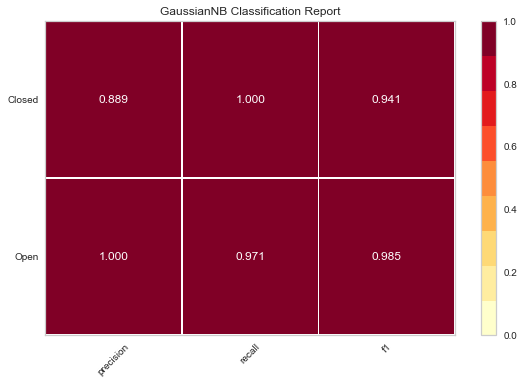

In [26]:
from yellowbrick.classifier import ClassificationReport
ocgnb = ClassificationReport(gnb, classes=['Open','Closed'])
ocgnb.fit(data_train, target_train)
ocgnb.score(data_test, target_test)
gnbacc = ocgnb.poof() 

### Linear Support Vector Classification

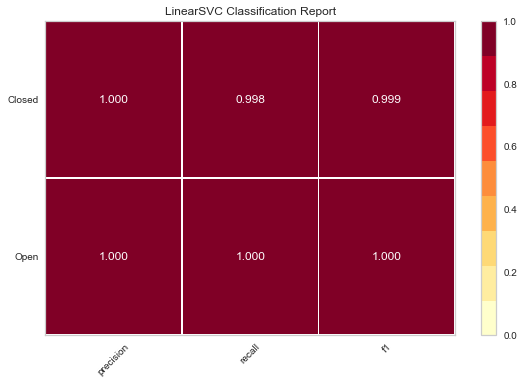

In [27]:
oclsvc = ClassificationReport(lsvc, classes=['Open','Closed'])
oclsvc.fit(data_train, target_train)
oclsvc.score(data_test, target_test)
lsvcacc = oclsvc.poof()

### K Neighbor Classification

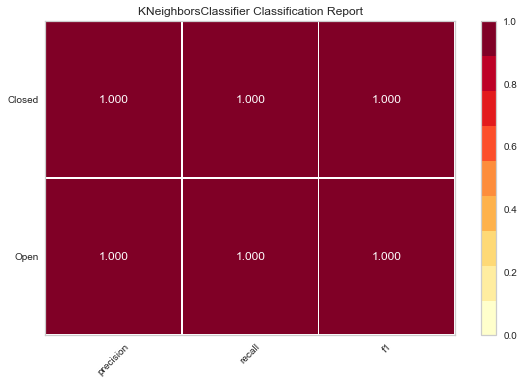

In [28]:
ocknc = ClassificationReport(knc, classes=['Open','Closed'])
ocknc.fit(data_train, target_train) # Fit the training data to the visualizer
ocknc.score(data_test, target_test) # Evaluate the model on the test data
kncacc = ocknc.poof()

## Conclusion and recommendations
* Public Works Department, Transportation - Traffic Division, Mayor's 24 Hour Hotline and Parks & Recreation are being handeled well with quicker rate of resolution accross all the wards and districts
* Districts listed under Fire districts and City council are different from the data set description, yet they seem to have common issue which is also established in association analysis. This trend can be used to reduce the cases being logged from alternate districts
* Service requests that are realted to government and policy modification do not have location information captured. In future if this information can be captured, there could be a possibility to understand the political mindset of the people living in certain district. Maybe, this analysis can be used to support election campaings
* K Neighbor Classification being the most accurate model, based on this predictive algorithm, by the end of the month, the number of open cases may reamin in the same range as it is today
* Cases registered through Citizens Connect App are more, making the app more user friendly to users of all age groups may help improve the community engagement

References:
    * Association Analysis: https://medium.com/analytics-vidhya/association-analysis-in-python-2b955d0180c
    
    * sklearn: https://scikit-learn.org/stable/index.html